# Diabetes Prediction Using PySpark MLlib


This project predicts diabetes using the CDC BRFSS 2015 dataset and compares
five machine learning models (Logistic Regression, Random Forest, Decision Tree, Support Vector Machine, and Gradient Boosted Trees) using PySpark MLlib.


## Import Required Libraries

We begin by importing PySpark MLlib components, evaluation metrics, and utility functions required for data preprocessing and model training.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Spark core
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col

# ML features
from pyspark.ml.feature import Imputer, VectorAssembler

# ML classification models
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    DecisionTreeClassifier,
    LinearSVC,
    GBTClassifier
)

# ML evaluation
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)

# Additional utilities
from pyspark.sql.functions import col, explode, array, lit
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder




## Create Spark Session

A Spark session is initialized to process the CDC BRFSS dataset using PySpark MLlib.


In [7]:
# Create Spark session
spark = SparkSession.builder.appName("DiabetesAnalysis").getOrCreate()

## Load Dataset and Inspect Schema
The CDC BRFSS 2015 Diabetes dataset is loaded from CSV format using PySpark.  
Inspecting the schema ensures that all columns are correctly typed and helps validate the preprocessing steps that follow.


In [8]:
# Load dataset with header and automatic schema inference
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("/content/diabetes_binary_health_indicators_BRFSS2015.csv")


In [9]:
df.printSchema()

root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [10]:
# Display summary statistics for numerical features
df.describe().show()

+-------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-----------------+
|summary|    Diabetes_binary|             HighBP|           HighChol|          CholCheck|               BMI|             Smoker|             Stroke|HeartDiseaseorAttack|      PhysActivity|             Fruits|            Veggies|  HvyAlcoholConsump|      AnyHealthcare|        NoDocbcCost|           GenHlth|          MentHlth|          PhysHlth|           DiffWalk|                Sex|               Age|         Education|           Income|
+-------+-------------------+-------------------+-------------------+-------------------+------------------+--------

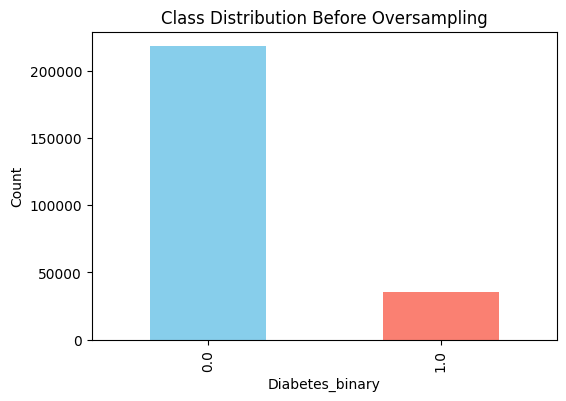

In [11]:
# Class Distribution Before Oversampling (Visualization)

pdf = df.toPandas()

plt.figure(figsize=(6,4))
pdf['Diabetes_binary'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.show()


In [12]:
# Quick check of binary distribution for the 'Smoker' feature
df.groupBy('Smoker').count().show()

+------+------+
|Smoker| count|
+------+------+
|   0.0|141257|
|   1.0|112423|
+------+------+



In [13]:
# Check for missing values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|              0|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|
+---------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+------------

In [14]:
all_columns = df.columns  # Get all column names
label = 'Diabetes_binary'  # Define the label column

# Generate the list of feature columns by excluding the label column
feature_columns = [col for col in all_columns if col != label]

# Now, feature_columns contains all columns except the label
print(feature_columns)

# Use these feature columns in VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)


['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


In [15]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)# Using a fixed seed ensures reproducible results


### Logistic Regression Model
We train a logistic regression classifier and evaluate it using Accuracy, Precision, Recall, F1-score, and AUC.


In [16]:
# Train Logistic Regression Model
lr = LogisticRegression(featuresCol='features', labelCol='Diabetes_binary')
lr_model = lr.fit(train_data)

# Make predictions
predictions_lr = lr_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_binary', metricName='areaUnderROC')
auc_lr = evaluator.evaluate(predictions_lr)
evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary')
accuracy_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "accuracy"})
precision_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedPrecision"})
recall_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedRecall"})
f1_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "f1"})

# Print metrics
print(f"Logistic Regression Metrics:\nAccuracy: {accuracy_lr}\nPrecision: {precision_lr}\nRecall: {recall_lr}\nF1-Score: {f1_lr}\nAUC: {auc_lr}")

Logistic Regression Metrics:
Accuracy: 0.8638250979003089
Precision: 0.8311768885535531
Recall: 0.8638250979003089
F1-Score: 0.8305400617297889
AUC: 0.8236746249827901


### Random Forest Classifier



In [17]:
# Train Random Forest Model
rf = RandomForestClassifier(featuresCol='features', labelCol='Diabetes_binary')
rf_model = rf.fit(train_data)

# Make predictions
predictions_rf = rf_model.transform(test_data)

# Evaluate the model
auc_rf = evaluator.evaluate(predictions_rf)
accuracy_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "accuracy"})
precision_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedPrecision"})
recall_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedRecall"})
f1_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "f1"})

# Print metrics
print(f"Random Forest Metrics:\nAccuracy: {accuracy_rf}\nPrecision: {precision_rf}\nRecall: {recall_rf}\nF1-Score: {f1_rf}\nAUC: {auc_rf}")

Random Forest Metrics:
Accuracy: 0.8599877993584824
Precision: 0.7395790150454453
Recall: 0.8599877993584824
F1-Score: 0.7952514691768723
AUC: 0.8071974157178307


### Decision Tree Classifier


In [18]:
# Train Decision Tree Model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Diabetes_binary')
dt_model = dt.fit(train_data)

# Make predictions
predictions_dt = dt_model.transform(test_data)

# Evaluate the model
auc_dt = evaluator.evaluate(predictions_dt)
accuracy_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "accuracy"})
precision_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "weightedPrecision"})
recall_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "weightedRecall"})
f1_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "f1"})

# Print metrics
print(f"Decision Tree Metrics:\nAccuracy: {accuracy_dt}\nPrecision: {precision_dt}\nRecall: {recall_dt}\nF1-Score: {f1_dt}\nAUC: {auc_dt}")

Decision Tree Metrics:
Accuracy: 0.8653600173170396
Precision: 0.8357924684510837
Recall: 0.8653600173170396
F1-Score: 0.8209812620880086
AUC: 0.4721271948747109


### Support Vector Machine (Linear SVC)
Note: AUC cannot be calculated due to missing probability outputs in PySpark's LinearSVC.


In [19]:
# Initialize the SVM model
svm = LinearSVC(featuresCol='features', labelCol='Diabetes_binary')

# Train the SVM model
svm_model = svm.fit(train_data)

# Make predictions on the test data
predictions_svm = svm_model.transform(test_data)

# Evaluators for multi-class classification metrics
evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary')

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "accuracy"})
precision_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "weightedPrecision"})
recall_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "weightedRecall"})
f1_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "f1"})

# Print metrics - Note: AUC is not calculated for LinearSVC due to the lack of probability output in PySpark's implementation
print(f"SVM (Linear SVC) Metrics:\nAccuracy: {accuracy_svm}\nPrecision: {precision_svm}\nRecall: {recall_svm}\nF1-Score: {f1_svm}")

SVM (Linear SVC) Metrics:
Accuracy: 0.8599877993584824
Precision: 0.7395790150454453
Recall: 0.8599877993584824
F1-Score: 0.7952514691768723


### Gradient Boosted Trees Classifier (GBT)

In [20]:
# Initialize the GBT model
gbt = GBTClassifier(featuresCol='features', labelCol='Diabetes_binary', maxIter=10)

# Train the GBT model on the training data
gbt_model = gbt.fit(train_data)

# Make predictions on the test data
predictions_gbt = gbt_model.transform(test_data)

# Initialize evaluators
evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary')
evaluator_binary = BinaryClassificationEvaluator(labelCol='Diabetes_binary', rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluate the model using different metrics
accuracy_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "accuracy"})
precision_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "weightedPrecision"})
recall_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "weightedRecall"})
f1_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "f1"})
auc_gbt = evaluator_binary.evaluate(predictions_gbt)

# Print metrics
print(f"Gradient Boosting Tree Metrics:\nAccuracy: {accuracy_gbt}\nPrecision: {precision_gbt}\nRecall: {recall_gbt}\nF1-Score: {f1_gbt}\nAUC: {auc_gbt}")

Gradient Boosting Tree Metrics:
Accuracy: 0.8662849046578901
Precision: 0.8372330660990508
Recall: 0.8662849046578901
F1-Score: 0.8252909160633487
AUC: 0.8232714648591226


In [21]:
# Get feature importances from the GBT model
importances = gbt_model.featureImportances

# Zip feature names with their importances
feature_importance_list = [(feature, importances[idx]) for idx, feature in enumerate(feature_columns) if importances[idx]]

# Sort the features by their importance scores in descending order
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Display the feature importances
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature:<20} {importance}")

Feature Importances:
GenHlth              0.19628417317413016
HighBP               0.19240535171556003
BMI                  0.15664555616405906
Age                  0.1329172210011273
HeartDiseaseorAttack 0.08728506358222893
HighChol             0.06787966201294657
DiffWalk             0.05289109242641211
HvyAlcoholConsump    0.03956443821909225
Income               0.03340338169673897
CholCheck            0.01649212328349046
Sex                  0.010297150829579074
Stroke               0.0045571585164485414
PhysHlth             0.002600880059691401
Education            0.0021756288929454335
MentHlth             0.0017715709676030113
PhysActivity         0.0008113828386714214
NoDocbcCost          0.0007720881692210133
Veggies              0.0005909248987500895
Smoker               0.0005372389550961598
AnyHealthcare        0.00011791259620815277


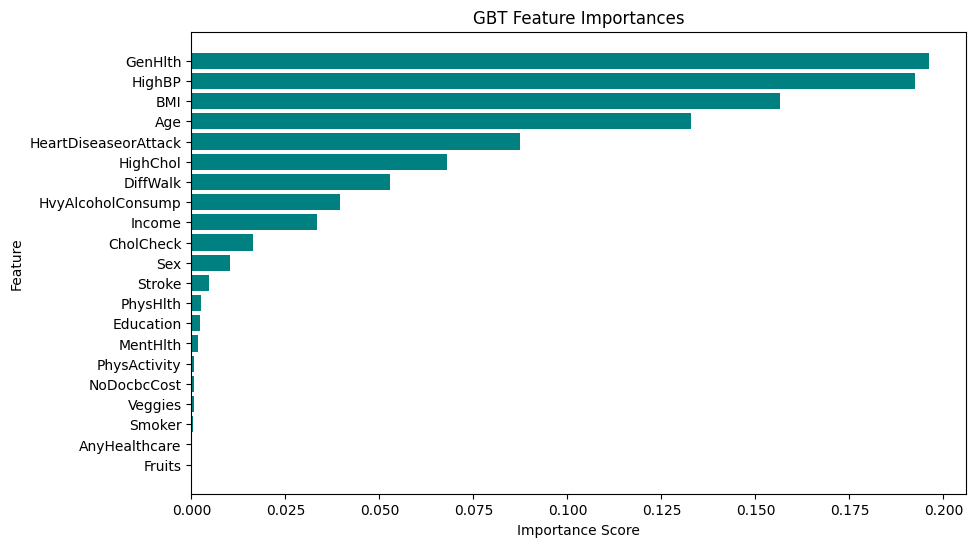

In [22]:
# Visualize Feature Importances

importances = gbt_model.featureImportances
feature_cols = feature_columns  # use the same list as used in VectorAssembler

# Convert to pandas-friendly structure
fi_list = [(feature_cols[i], importance) for i, importance in enumerate(importances)]
fi_sorted = sorted(fi_list, key=lambda x: x[1], reverse=True)

# Create a bar plot
plt.figure(figsize=(10,6))
plt.barh([x[0] for x in fi_sorted], [x[1] for x in fi_sorted], color='teal')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("GBT Feature Importances")
plt.gca().invert_yaxis()  # highest importance on top
plt.show()


### Final Accuracy Comparison


In [23]:
results = {
    "Logistic Regression": accuracy_lr,
    "Random Forest": accuracy_rf,
    "Decision Tree": accuracy_dt,
    "SVM": accuracy_svm,
    "GBTs": accuracy_gbt
}
results
sorted(results.items(), key=lambda x: x[1], reverse=True)


[('GBTs', 0.8662849046578901),
 ('Decision Tree', 0.8653600173170396),
 ('Logistic Regression', 0.8638250979003089),
 ('Random Forest', 0.8599877993584824),
 ('SVM', 0.8599877993584824)]

### Handling Class Imbalance (Oversampling the Minority Class)
Since the dataset is highly imbalanced, we oversample the minority class to avoid biased model training.


In [24]:
# Filter the majority and minority classes
major_df = df.filter(col("Diabetes_binary") == 0)
minor_df = df.filter(col("Diabetes_binary") == 1)

# Calculate counts for balancing
major_count = major_df.count()
minor_count = minor_df.count()

# Calculate the multiplier for oversampling the minority class
multiplier = int(major_count / minor_count)


# Oversample the minority class
oversampled_minor_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(multiplier)]))).drop("dummy")

# Combine back the oversampled minority class with the majority class
balanced_df = major_df.unionAll(oversampled_minor_df)

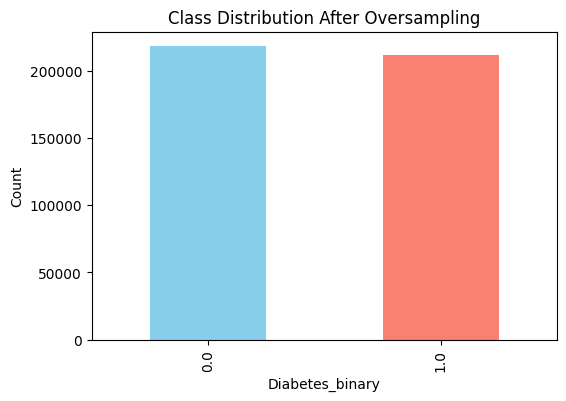

In [25]:
# Class Distribution After Oversampling (Visualization)

balanced_pdf = balanced_df.toPandas()

plt.figure(figsize=(6,4))
balanced_pdf['Diabetes_binary'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution After Oversampling')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.show()


In [26]:
# Define feature columns by excluding the label column
feature_columns_balanced = [col for col in balanced_df.columns if col != 'Diabetes_binary']

# Use these feature columns in VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns_balanced, outputCol="features")
df_assembled_balanced = assembler.transform(balanced_df)

# Split the balanced dataset
train_data, test_data = df_assembled_balanced.randomSplit([0.8, 0.2], seed=42)

### Logistic Regression with Cross-Validation (on Balanced Data)


In [27]:
# Initialize Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='Diabetes_binary')

# Create ParamGrid for Cross Validation
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()

# Set up CrossValidator
crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(labelCol='Diabetes_binary'),
                             numFolds=3)

# Fit and transform
cvModel_lr = crossval_lr.fit(train_data)
predictions_lr = cvModel_lr.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_binary')
auc_cv_lr = evaluator.evaluate(predictions_lr)

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction")
accuracy_cv_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "accuracy"})
precision_cv_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedPrecision"})
recall_cv_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "weightedRecall"})
f1_cv_lr = evaluator_multi.evaluate(predictions_lr, {evaluator_multi.metricName: "f1"})

# Print metrics
print("Logistic Regression with Cross-Validation Metrics:")
print(f"Accuracy: {accuracy_cv_lr}")
print(f"Precision: {precision_cv_lr}")
print(f"Recall: {recall_cv_lr}")
print(f"F1 Score: {f1_cv_lr}")
print(f"AUC: {auc_cv_lr}")

Logistic Regression with Cross-Validation Metrics:
Accuracy: 0.7452090794920694
Precision: 0.7456536731991719
Recall: 0.7452090794920694
F1 Score: 0.7452042700843682
AUC: 0.8212545345496591


### Random Forest with Cross-Validation (on Balanced Data)


In [28]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Diabetes_binary')

# Create the parameter grid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5]) \
    .addGrid(rf.numTrees, [20]) \
    .build()

# Set up CrossValidator
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(labelCol='Diabetes_binary'),
                             numFolds=3)

# Fit the model
cvModel_rf = crossval_rf.fit(train_data)

# Make predictions
predictions_rf = cvModel_rf.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_binary')
auc_cv_rf = evaluator.evaluate(predictions_rf)

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction")
accuracy_cv_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "accuracy"})
precision_cv_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedPrecision"})
recall_cv_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "weightedRecall"})
f1_cv_rf = evaluator_multi.evaluate(predictions_rf, {evaluator_multi.metricName: "f1"})

# Print metrics
print("Random Forest with Cross-Validation Metrics:")
print(f"Accuracy: {accuracy_cv_rf}")
print(f"Precision: {precision_cv_rf}")
print(f"Recall: {recall_cv_rf}")
print(f"F1 Score: {f1_cv_rf}")
print(f"AUC: {auc_cv_rf}")

Random Forest with Cross-Validation Metrics:
Accuracy: 0.7360226057025908
Precision: 0.7380989628308643
Recall: 0.7360226057025907
F1 Score: 0.735730512815991
AUC: 0.8118327410924534


### Decision Tree with Cross-Validation (on Balanced Data)



In [29]:
# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Diabetes_binary')

# Create the parameter grid
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5]) \
    .build()

# Set up CrossValidator
crossval_dt = CrossValidator(estimator=dt,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=BinaryClassificationEvaluator(labelCol='Diabetes_binary'),
                             numFolds=3)

# Fit the model
cvModel_dt = crossval_dt.fit(train_data)

# Make predictions
predictions_dt = cvModel_dt.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_binary')
auc_cv_dt = evaluator.evaluate(predictions_dt)

evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction")
accuracy_cv_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "accuracy"})
precision_cv_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "weightedPrecision"})
recall_cv_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "weightedRecall"})
f1_cv_dt = evaluator_multi.evaluate(predictions_dt, {evaluator_multi.metricName: "f1"})

# Print metrics
print("Decision Tree with Cross-Validation Metrics:")
print(f"Accuracy: {accuracy_cv_dt}")
print(f"Precision: {precision_cv_dt}")
print(f"Recall: {recall_cv_dt}")
print(f"F1 Score: {f1_cv_dt}")
print(f"AUC: {auc_cv_dt}")

Decision Tree with Cross-Validation Metrics:
Accuracy: 0.7302781524722081
Precision: 0.7332080212949114
Recall: 0.730278152472208
F1 Score: 0.7297873717913401
AUC: 0.6848327542264546


### Gradient Boosted Trees with Cross-Validation (on Balanced Data)


In [30]:
# Initialize the GBT classifier
gbt = GBTClassifier(featuresCol='features', labelCol='Diabetes_binary')

# Create the parameter grid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5]) \
    .addGrid(gbt.maxIter, [10]) \
    .build()

# Set up CrossValidator
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=BinaryClassificationEvaluator(labelCol='Diabetes_binary'),
                              numFolds=3)

# Fit the model
cvModel_gbt = crossval_gbt.fit(train_data)

# Make predictions
predictions_gbt = cvModel_gbt.transform(test_data)

# Evaluate the model using the BinaryClassificationEvaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_binary')
auc_cv_gbt = evaluator.evaluate(predictions_gbt)

# Evaluate the model using the MulticlassClassificationEvaluator for accuracy, precision, recall, and F1-score
evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction")
accuracy_cv_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "accuracy"})
precision_cv_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "weightedPrecision"})
recall_cv_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "weightedRecall"})
f1_cv_gbt = evaluator_multi.evaluate(predictions_gbt, {evaluator_multi.metricName: "f1"})

# Print metrics
print("Gradient-Boosted Trees with Cross-Validation Metrics:")
print(f"Accuracy: {accuracy_cv_gbt}")
print(f"Precision: {precision_cv_gbt}")
print(f"Recall: {recall_cv_gbt}")
print(f"F1 Score: {f1_cv_gbt}")
print(f"AUC: {auc_cv_gbt}")

Gradient-Boosted Trees with Cross-Validation Metrics:
Accuracy: 0.7454300200009303
Precision: 0.748722589396107
Recall: 0.7454300200009303
F1 Score: 0.7449217260954759
AUC: 0.8223149942444229


### Support Vector Machine (LinearSVC) with Cross-Validation (on Balanced Data)


In [31]:

# Initialize the SVM model
svm = LinearSVC(featuresCol='features', labelCol='Diabetes_binary')

# Create the parameter grid
paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10]) \
    .addGrid(svm.regParam, [0.01]) \
    .build()

# Set up CrossValidator
crossval_svm = CrossValidator(estimator=svm,
                              estimatorParamMaps=paramGrid_svm,
                              evaluator=MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction", metricName="f1"),
                              numFolds=3)

# Fit the model
cvModel_svm = crossval_svm.fit(train_data)

# Make predictions
predictions_svm = cvModel_svm.transform(test_data)

# Evaluate the model
evaluator_multi = MulticlassClassificationEvaluator(labelCol='Diabetes_binary', predictionCol="prediction")
accuracy_cv_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "accuracy"})
precision_cv_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "weightedPrecision"})
recall_cv_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "weightedRecall"})
f1_cv_svm = evaluator_multi.evaluate(predictions_svm, {evaluator_multi.metricName: "f1"})

# Print metrics
print("SVM (Linear SVC) with Cross-Validation Metrics:")
print(f"Accuracy: {accuracy_cv_svm}")
print(f"Precision: {precision_cv_svm}")
print(f"Recall: {recall_cv_svm}")
print(f"F1 Score: {f1_cv_svm}")
# Did not include AUC because LinearSVC does not provide probability estimates needed for AUC calculation.

SVM (Linear SVC) with Cross-Validation Metrics:
Accuracy: 0.7450579096702172
Precision: 0.7473281621574337
Recall: 0.7450579096702172
F1 Score: 0.7447490043975251


In [32]:
# Compare model accuracies for balanced dataset (Cross-Validation)

balanced_results = {
    "Logistic Regression (CV)": accuracy_cv_lr,
    "Random Forest (CV)": accuracy_cv_rf,
    "Decision Tree (CV)": accuracy_cv_dt,
    "SVM (CV)": accuracy_cv_svm,
    "GBT (CV)": accuracy_cv_gbt
}

balanced_results
sorted(balanced_results.items(), key=lambda x: x[1], reverse=True)

[('GBT (CV)', 0.7454300200009303),
 ('Logistic Regression (CV)', 0.7452090794920694),
 ('SVM (CV)', 0.7450579096702172),
 ('Random Forest (CV)', 0.7360226057025908),
 ('Decision Tree (CV)', 0.7302781524722081)]

### Accuracy Comparison: Balanced vs Unbalanced Data

This visualization compares model performance on the **original unbalanced dataset** versus the **oversampled balanced dataset**.

- The unbalanced dataset has a strong majority–minority class skew, which can bias models.
- After oversampling, the minority class is replicated to match the majority count, helping reduce bias.
- Each model displays two bars:
  - **Unbalanced (light gray)** – performance before oversampling
  - **Balanced (steel blue)** – performance after oversampling
  
The chart makes it easy to see whether oversampling improved model accuracy and how models behave under different data distributions.


In [39]:

models = ['LR', 'RF', 'DT', 'SVM', 'GBT']

# accuracies BEFORE balancing
accuracies_unbalanced = [
    accuracy_lr,
    accuracy_rf,
    accuracy_dt,
    accuracy_svm,
    accuracy_gbt
]

# accuracies AFTER balancing
accuracies_balanced = [
    accuracy_cv_lr,
    accuracy_cv_rf,
    accuracy_cv_dt,
    accuracy_cv_svm,
    accuracy_cv_gbt
]

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Unbalanced',
    x=models,
    y=accuracies_unbalanced,
    marker_color='lightgray',
    width=0.35,
    hovertemplate='Unbalanced Accuracy: %{y:.4f}<extra></extra>',
    text=[f"{x:.3f}" for x in accuracies_unbalanced],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Balanced (Oversampling)',
    x=models,
    y=accuracies_balanced,
    marker_color='steelblue',
    width=0.35,
    hovertemplate='Balanced Accuracy: %{y:.4f}<extra></extra>',
    text=[f"{x:.3f}" for x in accuracies_balanced],
    textposition='outside'
))

fig.update_layout(
    barmode='group',
    title='Accuracy Comparison: Balanced vs Unbalanced Data',
    title_x=0.5,
    xaxis_title='Models',
    yaxis_title='Accuracy',
    template='plotly_white',
    width=750,
    height=420,
    yaxis=dict(range=[0, 1]),
    margin=dict(l=60, r=40, t=80, b=60)
)

fig.show()


## Conclusion

Gradient Boosted Trees achieved the highest overall accuracy on both the raw and balanced datasets. Oversampling and cross-validation improved model stability and reduced bias toward the majority class.
